# Tarea 3 - Optimización
- Integrantes: 
    - Samuel Coña J. - 
    - Daniel Lopez B. -
    - Dayan Sáez C. - 2020444854
    - Luis Valenzuela C. - 2020437548

Instancia a resolver:

<table>
  <tr>
    <th></th>
    <th colspan="4">
      Máquinas r</th>
  </tr>
  <tr>
    <th>Trabajo i</th>
    <th>M<sub>1</th>
    <th>M<sub>2</th>
    <th>M<sub>3</th>
    <th>M<sub>4</th>
  </tr>
  <tr>
    <th>J<sub>1</th>
    <th>9</th>
    <th>13</th>
    <th>15</th>
    <th>20</th>
  </tr>
  <tr>
    <th>J<sub>2</th>
    <th>11</th>
    <th>17</th>
    <th>18</th>
    <th>24</th>
  </tr>
  <tr>
    <th>J<sub>3</th>
    <th>8</th>
    <th>12</th>
    <th>14</th>
    <th>18</th>
  </tr>
  <tr>
    <th>J<sub>4</th>
    <th>6</th>
    <th>10</th>
    <th>12</th>
    <th>15</th>
  </tr>

In [37]:
T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

### Párametros de los modelos
$ T_{ir} \text{: Duración de proceso del trabajo i en maquina r.} \\$
$ B_{jr} \text{: Tiempo de inicio del trabajo j, en la posición de la secuencia, en máquina r.} \\$
$ C_{ir} \text{: Tiempo de finalización del trabajo i en la máquina r.} \\$
$ D_{ik} \text{: 1 si el } \\$
$ E_{jr} \text{: Hola} \\$
$ S_{ir} \text{: Hola} \\$
$ X_{jr} \text{: Hola} \\$
$ Y_{jr} \text{: Hola} \\$
$ Z_{jr} \text{: Hola} \\$

### Modelo Wagner

$$ Min \quad C_{max} = C_{MN} $$
$$ \sum_{j=1}^{N} Z_{ij} = 1; \quad (1 \le i \le N), \quad (1) $$ 
$$ \sum_{i=1}^{N} Z_{ij} = 1; \quad (1 \le j \le N), \quad (2)$$
$$ \sum_{i=1}^{N} T_{ri}Z_{i,j+1} - \sum_{i=1}^{N} T_{r+1,i}Z_{ij} + X_{r,j+1} - X_{r+1,j+1} + Y_{r,j+1} - Y_{rj} = 0; \quad (1 \le r \le M-1;1 \le j \le N-1), \quad (3)
$$

$$ \sum_{i=1}^{N} T_{ri}Z_{i1} + X_{r1} - X_{r+1,1} + Y_{r1} = 0; \quad (1 \le r \le M-1), \quad (4) $$

$$ C_{MN} = \sum_{i=1}^{N} T_{Mi} + \sum_{p=1}^{N} X_{Mp}. \quad (5) $$

#### Implementación en PuLP

In [66]:
import pulp as lp
import numpy as np

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the LP problem
model = lp.LpProblem("Wagner_Model", lp.LpMinimize)

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
X = lp.LpVariable.dicts("X", (range(M), range(N)), lowBound=0, cat='Integer')
Y = lp.LpVariable.dicts("Y", (range(M), range(N)), lowBound=0, cat='Integer')

# Define the objective function
model += lp.lpSum(T[i][M - 1] for i in range(N)) + lp.lpSum(X[i][M - 1] for i in range(N))

# Define the constraints
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

for r in range(M - 1):
    for j in range(N - 1):
        model += lp.lpSum(T[i][r] * Z[i][j + 1] for i in range(N)) - lp.lpSum(T[i][r + 1] * Z[i][j] for i in range(N)) + \
                  X[j + 1][r] - X[j + 1][r + 1] + Y[j + 1][r] - Y[j][r] == 0

for r in range(M - 1):
    model += lp.lpSum(T[i][r] * Z[i][0] for i in range(N)) +  X[0][r] - X[0][r + 1] + Y[0][r] == 0

# Solve the LP problem
solution = model.solve()

# Print the optimal solution
print("Objective Value:", lp.value(model.objective))

for i in range(N):
    for j in range(N):
        print(f"X_{i}_{j} = {lp.value(X[i][j])}")


Objective Value: 105.0
X_0_0 = 0.0
X_0_1 = 6.0
X_0_2 = 16.0
X_0_3 = 28.0
X_1_0 = 0.0
X_1_1 = 0.0
X_1_2 = 0.0
X_1_3 = 0.0
X_2_0 = 0.0
X_2_1 = 0.0
X_2_2 = 0.0
X_2_3 = 0.0
X_3_0 = 0.0
X_3_1 = 0.0
X_3_2 = 1.0
X_3_3 = 0.0


#### Carta Gantt   

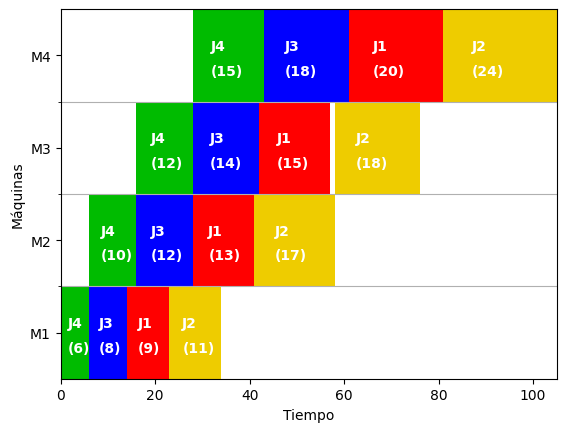

In [39]:
import matplotlib.pyplot as plt

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = lp.value(model.objective)
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

matriz = [[0 for x in range(N)] for y in range(M)]
for i in range(M):
    inicio = lp.value(X[0][i])
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (i > 0):
            if(matriz[i-1][j][1] > inicio):
                inicio += lp.value(X[j][i])
        termino = inicio + duracion_tarea
        matriz[i][j] = [int(inicio), int(termino)]
        inicio = termino

for i in range(M):
    for j in range(N):
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        inicio = matriz[i][j][0]
        duracion_tarea = matriz[i][j][1] - matriz[i][j][0]
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')

#### Implementación en CPLEX

In [87]:
from docplex.mp.model import Model
import numpy as np

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the model
model = Model(name="Wagner_Model")

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = {(i, j): model.binary_var(name=f"Z_{i}_{j}") for i in range(N) for j in range(M)}
X = {(i, j): model.integer_var(name=f"X_{i}_{j}", lb=0) for i in range(N) for j in range(M)}
Y = {(i, j): model.integer_var(name=f"Y_{i}_{j}", lb=0) for i in range(N) for j in range(M)}

# Define the objective function
model.minimize(model.sum(T[i][M - 1]for i in range(N)) + model.sum(X[p, M - 1] for p in range(N)))

# Define the constraints
for i in range(N):
    model.add_constraint(model.sum(Z[i, j] for j in range(N)) == 1)
    
for j in range(N):
    model.add_constraint(model.sum(Z[i, j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.add_constraint(model.sum(T[i][r] * Z[i, j + 1] for i in range(N)) -
                             model.sum(T[i][r + 1] * Z[i, j] for i in range(N)) +
                             X[j + 1, r] - X[j + 1, r + 1] + Y[j + 1, r] - Y[j, r] == 0)

for r in range(M - 1):
    model.add_constraint(model.sum(T[i][r] * Z[i, 0] for i in range(N)) +
                         X[0, r] - X[0, r + 1] + Y[0, r] == 0)

# Solve the model
solution = model.solve()
# Print the optimal solution
print("Objective Value:", solution.get_objective_value())


Objective Value: 105.0


#### Carta Gantt   

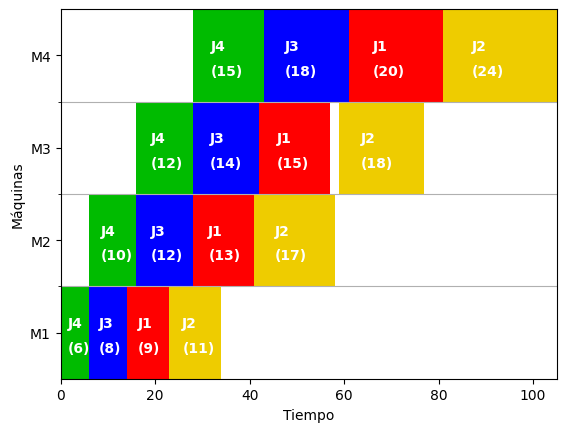

In [86]:
import matplotlib.pyplot as plt

unos_tareas = [(i, j) for i in range(N) for j in range(N) if solution.get_value(Z[i, j]) == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = solution.get_objective_value()
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

matriz = [[0 for x in range(N)] for y in range(M)]
for i in range(M):
    inicio = solution.get_value(X[0, i])
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (i > 0):
            if(matriz[i-1][j][1] > inicio):
                inicio += solution.get_value(X[j, i])
        termino = inicio + duracion_tarea
        matriz[i][j] = [int(inicio), int(termino)]
        inicio = termino

for i in range(M):
    for j in range(N):
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        inicio = matriz[i][j][0]
        duracion_tarea = matriz[i][j][1] - matriz[i][j][0]
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')

#### Implementación en GUROBI

In [117]:
import gurobipy as gp

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the model
model = gp.Model("Wagner_Model")

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines
Z = model.addVars(N, N, vtype=gp.GRB.BINARY, name="Z")
X = model.addVars(M, N, vtype=gp.GRB.INTEGER, lb=0, name="X")
Y = model.addVars(M, N, vtype=gp.GRB.INTEGER, lb=0, name="Y")

# Define the objective function
model.setObjective(gp.quicksum(T[i][M - 1] * Z[i, j] for i in range(N) for j in range(M)) +
                   gp.quicksum(X[i, M - 1] for i in range(N)), gp.GRB.MINIMIZE)

# Define the constraints
for i in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for j in range(N)) == 1)
    
for j in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.addConstr(gp.quicksum(T[i][r] * Z[i, j + 1] for i in range(N)) -
                        gp.quicksum(T[i][r + 1] * Z[i, j] for i in range(N)) +
                        X[j + 1, r] - X[j + 1, r + 1] + Y[j + 1, r] - Y[j, r] == 0)

for r in range(M - 1):
    model.addConstr(gp.quicksum(T[i][r] * Z[i, 0] for i in range(N)) +
                    X[0, r] - X[0, r + 1] + Y[0, r] == 0)

# Solve the model
model.setParam('OutputFlag', False)
model.optimize()

# Print the optimal solution
print("Objective Value:", model.objVal)

for i in range(M):
    for j in range(N):
        print(f"Y[{i}, {j}] = {Y[i, j].x}")
for i in range(N):
    for j in range(N):
        if (Z[i, j].x == 1):
            print(f"Z[{j+1}, {i+1}] = {Z[i, j].x}")



Objective Value: 105.0
Y[0, 0] = 0.0
Y[0, 1] = 0.0
Y[0, 2] = 0.0
Y[0, 3] = -0.0
Y[1, 0] = 2.0
Y[1, 1] = 1.0
Y[1, 2] = -0.0
Y[1, 3] = -0.0
Y[2, 0] = 5.0
Y[2, 1] = 2.0
Y[2, 2] = 3.0
Y[2, 3] = -0.0
Y[3, 0] = -0.0
Y[3, 1] = 0.0
Y[3, 2] = 5.0
Y[3, 3] = -0.0
Z[3, 1] = 1.0
Z[4, 2] = 1.0
Z[2, 3] = 1.0
Z[1, 4] = 1.0


#### Carta Gantt   

Y[3, 2] = -0.0


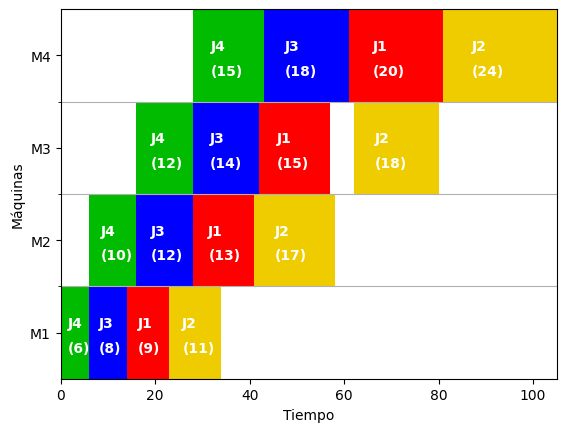

In [124]:
import matplotlib.pyplot as plt

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].x == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = model.objVal
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

matriz = [[0 for x in range(N)] for y in range(M)]
for i in range(M):
    inicio = X[0, i].x
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (i > 0):
            if(matriz[i-1][j][1] > inicio):
                inicio += min(X[j, i].x, Y[j-1, i].x)
                print(f"Y[{j}, {i}] = {X[j, i].x}")
        termino = inicio + duracion_tarea
        matriz[i][j] = [int(inicio), int(termino)]
        inicio = termino

for i in range(M):
    for j in range(N):
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        inicio = matriz[i][j][0]
        duracion_tarea = matriz[i][j][1] - matriz[i][j][0]
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')

### Modelo Wilson
$$ Min \quad C_{max} = B_{MN} + \sum_{i=1}^{N}T_{Mi}Z_{iN} $$
$$ \sum_{j=1}^{N} Z_{ij} = 1; \quad (1 \le i \le N), \quad (1) $$ 
$$ \sum_{i=1}^{N} Z_{ij} = 1; \quad (1 \le j \le N), \quad (2)$$
$$ B_{1j}+\sum_{i=1}^{N} T_{1i}Z_{1j} = B_{1,j+1}; \quad (1\leq j \leq N-1), \quad (3)$$
$$ B_{11} = 0, \quad(4)$$
$$ B_{r1} + \sum_{i=1}^{N} T_{ri}Z_{i1} = B_{r+1,1}; \quad (1\leq r \leq M-1),\quad (5) $$

$$ B_{rj} + \sum_{i=1}^{N}T_{ri}Z_{ij} \leq B_{r+1,j}; \quad (1\leq r\leq M-1;2\leq j \leq N), \quad (6) $$
$$ B_{rj} + \sum_{i=1}^N T_{ri}Z_{ij} \leq B_{r,j+1}; \quad (2\leq r\leq M; 1\leq j\leq N-1). \quad (7) $$

In [44]:
import pulp as lp
import matplotlib.pyplot as plt
import numpy as np

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the LP problem
model = lp.LpProblem("Wagner_Model", lp.LpMinimize)

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
B = lp.LpVariable.dicts("B", (range(N), range(M)), lowBound=0, cat='Integer')

# Define the objective function
model += B[N-1][M-1] + lp.lpSum(T[i][M - 1] * Z[N-1][i] for i in range(N))

# Define the constraints
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

for j in range(N-1):
    model += B[j][0] + lp.lpSum(T[i][0] * Z[i][j] for i in range(N)) == B[j+1][0]

model += B[0][0] == 0

for r in range(M-1):
    model += (B[0][r] + lp.lpSum(T[i][r] * Z[i][0] for i in range(N)) == B[0][r+1])

for r in range(M-1):
    for j in range(N-1):
        model += (B[j][r] + lp.lpSum(T[i][r] * Z[i][j+1] for i in range(N))) <= B[j+1][r+1]
        
for r in range(M-1):
    for j in range(N-1):
        model += B[j][r+1] + lp.lpSum(T[i][r+1] * Z[i][j] for i in range(N)) <= B[j+1][r+1]

# Solve the LP problem
solution = model.solve()

# Print the optimal solution
print("Objective Value:", lp.value(model.objective))

for v in model.variables():
    print(v.name, "=", v.varValue)
print("Objective Value:", model.objective.value())


Objective Value: 101.0
B_0_0 = 0.0
B_0_1 = 6.0
B_0_2 = 16.0
B_0_3 = 28.0
B_1_0 = 6.0
B_1_1 = 50.0
B_1_2 = 28.0
B_1_3 = 43.0
B_2_0 = 14.0
B_2_1 = 62.0
B_2_2 = 63.0
B_2_3 = 61.0
B_3_0 = 23.0
B_3_1 = 75.0
B_3_2 = 79.0
B_3_3 = 81.0
Z_0_0 = 0.0
Z_0_1 = 0.0
Z_0_2 = 1.0
Z_0_3 = 0.0
Z_1_0 = 0.0
Z_1_1 = 0.0
Z_1_2 = 0.0
Z_1_3 = 1.0
Z_2_0 = 0.0
Z_2_1 = 1.0
Z_2_2 = 0.0
Z_2_3 = 0.0
Z_3_0 = 1.0
Z_3_1 = 0.0
Z_3_2 = 0.0
Z_3_3 = 0.0
Objective Value: 101.0


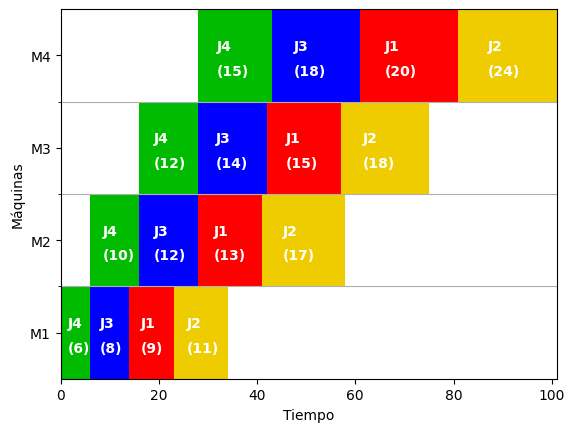

In [45]:
import matplotlib.pyplot as plt

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = lp.value(model.objective)
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

for i in range(M):
    inicio = lp.value(B[0][i])
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')
        inicio += duracion_tarea

### Modelo Manne

### Modelo Liao-You